<a href="https://colab.research.google.com/github/YassGan/MicroGrad/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [811]:
import math
import numpy as np
import matplotlib.pyplot as plt


In [812]:
def f(x):
  return 3*x**2 - 4*x + 1

In [813]:
xs=np.arange(-6,6,0.25)

xy=[]
for x in xs:
  xy.append(f(x))



In [814]:
class Value:
  def __init__(self, data, _children=(),_op="",label=""):
    self.data = data
    self._prev=set(_children)
    self._op=_op
    self.grad=0.0
    self.label=label
    self.grad=0
    self._backward=lambda:None




  def __repr__(self):
    return f'Value  {self.data}'





  def __add__(self,other):
    other = other if isinstance(other, Value) else Value(other)
    out=Value(self.data+other.data,(self,other),'+')

    def _backward():
      self.grad+=1.0*out.grad
      other.grad+=1.0*out.grad
    out._backward=_backward
    return out

  def __sub__(self, other): # self - other
      other = other if isinstance(other, Value) else Value(other)
      out = Value(self.data - other.data, (self, other), '-')
      def _backward():
          self.grad += 1.0 * out.grad
          other.grad -= 1.0 * out.grad
      out._backward = _backward
      return out


  def __mul__(self,other):
    other = other if isinstance(other, Value) else Value(other)
    out=Value(self.data*other.data,(self,other),'*')

    def _backward():
      self.grad+=other.data*out.grad
      other.grad+=self.data*out.grad
    out._backward=_backward
    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __pow__(self, other):
      assert isinstance(other, (int, float)), "only supporting int/float powers for now"
      out = Value(self.data**other, (self,), f'**{other}')

      def _backward():
          self.grad += other * (self.data**(other-1)) * out.grad
      out._backward = _backward

      return out


  def tanh(self):
    x=self.data
    t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
    out= Value(t,(self,),'tanh')

    def _backward():
      self.grad+=(1-t**2)*out.grad
    out._backward=_backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad=1
    for node in reversed (topo):
      node._backward()

In [815]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [816]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'


In [817]:
L.grad=1
f.grad=d.data*L.grad
d.grad=f.data*L.grad
e.grad=d.grad*1
c.grad=d.grad*1
a.grad=b.data*e.grad
b.grad=a.data*e.grad


In [818]:
# draw_dot(L)

In [819]:
a.data+=0.01  *a.grad

f.grad=d.data*L.grad
d.grad=f.data*L.grad
e.grad=d.grad*1
c.grad=d.grad*1
a.grad=b.data*e.grad
b.grad=a.data*e.grad

e.data=a.data*b.data
d.data=e.data+c.data
L.data=d.data*f.data

In [820]:
#inputs x1, x2
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')

#weights w1, w2
w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')

#bias of the neuron
b=Value(6.8813735870195432, label='b')

#x1*w1 + x2*w2 +b
x1w1=x1*w1; x1w1.label="x1*w1"
x2w2=x2*w2; x2w2.label="x2*w2"
x1w1x2w2=x1w1+x2w2;x1w1x2w2.label=" x1*w1 + x2*w2 "
n=x1w1x2w2+b; n.label='n'
o=n.tanh(); o.label='o'



In [821]:
x1w1x2w2.grad=0.5
b.grad=0.5
x1w1.grad=0.5
x2w2.grad=0.5

x1.grad=w1.data*x1w1.grad
w1.grad=x1.data*x1w1.grad
x2.grad=w2.data*x2w2.grad
w2.grad=x2.data*x2w2.grad


In [822]:
import torch
import random

In [823]:
x1=torch.Tensor([2.0]).double() ;x1.requires_grad=True
x2=torch.Tensor([0.0]).double() ;x2.requires_grad=True
w1=torch.Tensor([-3.0]).double() ;w1.requires_grad=True
w2=torch.Tensor([1.0]).double() ;w2.requires_grad=True
b=torch.Tensor([6.8813735870195432]).double() ;b.requires_grad=True
n=x1*w1+x2*w2+b
o=torch.tanh(n)

print(o.data.item())

0.7071066904050358


In [824]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self,x):
    # w * x + b
    act = sum((wi*(xi) for wi,xi in zip(self.w,x)), self.b)
    out = act.tanh()
    return out




class Layer:
  def __init__(self,nin,nout):
    self.neurons=[Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs)==1 else outs




class MLP:
  def __init__(self,nin,nouts):
    sz=[nin]+nouts
    self.layers=[Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

  def __call__(self,x):
    for layer in self.layers:
      x=layer(x)
    return(x)

x=[2.0,3.0,-1.0]
n=MLP(3,[4,4,1])
n(x)

Value  0.30536335661492026

In [825]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1, 1, -1],
]

ys = [1, -1, -1, 1]

n = MLP(3, [4, 4, 1])  # Use a unique name
ypred = [n(x) for x in xs]
print(ypred)


[Value  0.6704119745286129, Value  0.19120104189959133, Value  0.6632138491837016, Value  0.5730293538021424]


In [826]:
loss=sum( ((yout-ygt)**2 for ygt, yout in zip(ys,ypred)), start=Value(0))

loss

Value  4.47617242958788

In [827]:
loss.backward()

In [828]:
n.layers[0].neurons[0].w[0].grad

1.0476549489935092

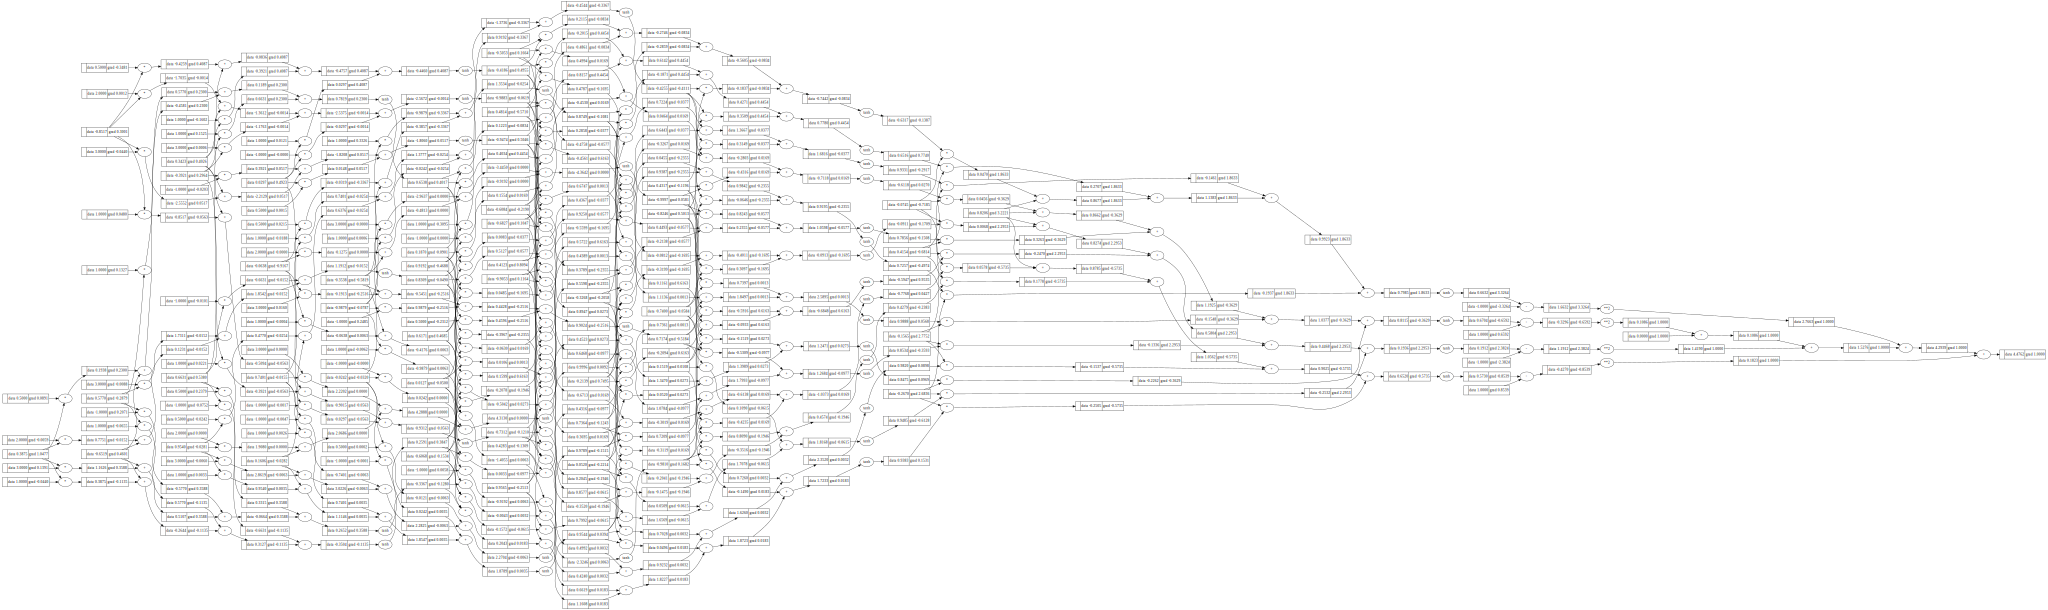

In [830]:
draw_dot(loss)